## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [3]:
import os
import shutil
import glob

## Arguments & Initializations

In [4]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [5]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [6]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [45]:
DATASET = "law_race_aif"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [46]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [47]:
ATTACK

'mia1'

## Loading & Splitting Dataset

In [48]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [49]:
dataset_orig.features.shape

(22342, 4)

In [50]:
privileged_groups

[{'race': 1}]

In [51]:
sens_attr

'race'

In [52]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [53]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[0.         0.         0.5        0.75      ]
 [1.         1.         0.81081081 0.8       ]
 [1.         1.         0.35135135 0.65      ]
 ...
 [1.         0.         0.58108108 0.625     ]
 [1.         0.         0.60810811 0.85      ]
 [0.         0.         0.54054054 0.7       ]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [54]:
seed = 1234
np.random.seed(seed)

In [55]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [56]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [57]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [58]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [59]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [60]:
target_dataset = None
reference_dataset = None

In [61]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

#### Train dataset's features are as below:
[[1.         0.         0.86486486 0.825     ]
 [1.         0.         0.64864865 0.9       ]
 [1.         0.         0.81081081 0.75      ]
 ...
 [1.         0.         0.86486486 0.9       ]
 [1.         0.         0.78378378 0.75      ]
 [1.         1.         0.59459459 0.85      ]]
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
privileged vs. unprivileged:  10290.0 881.0
base_pos unpriv:  0.06923950056753689
base_pos priv:  0.31982507288629736
number of favorable labels:  3352
Difference in mean outcomes between unprivileged and privileged groups = -0.250586
#### Train shape, validation shape, test shape
(11171, 4)

RUN DIRMITIGATOR
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 820
Number of test samples (ntest): 771
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 6999
Number of test samples (ntest): 7034
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3291
Number of test samples (ntest): 3317
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7819
         1.0       0.63      0.14      0.23      3352

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7173932503804494
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.34
Testing Original .

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 820
Number of test samples (ntest): 771
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 6999
Number of test samples (ntest): 7034
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3291
Number of test samples (ntest): 3317
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7819
         1.0       0.57      0.14      0.23      3352

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7104108853280816
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.41000000000000003
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7819, Test = 7805
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3352, Test = 3366
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -1.438723572658

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7071
Number of test samples (ntest): 6962
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3230
Number of test samples (ntest): 3378
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83      7882
         1.0       0.63      0.13      0.22      3289

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.52     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7214215379106615
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0

Number of training samples (ntrain): 7071
Number of test samples (ntest): 6962
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3230
Number of test samples (ntest): 3378
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7882
         1.0       0.59      0.12      0.21      3289

    accuracy                           0.72     11171
   macro avg       0.66      0.54      0.52     11171
weighted avg       0.68      0.72      0.64     11171

Train accuracy:  0.716587592874407
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0.

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 811
Number of test samples (ntest): 780
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 51
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7071
Number of test samples (ntest): 6962
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3230
Number of test samples (ntest): 3378
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7882
         1.0       0.57      0.13      0.21      3289

    accuracy                           0.72     11171
   macro avg       0.65      0.54      0.52     11171
weighted avg       0.68      0.72      0.64     11171

Train accuracy:  0.7150657953629934
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.02
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.665197616094677
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7882, Test = 7742
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.016710003828231165
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3289, Test = 3429
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.13
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -0.665197616094677
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7028
Number of test samples (ntest): 7005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3283
Number of test samples (ntest): 3325
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7838
         1.0       0.63      0.14      0.23      3333

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7194521528958912
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.34
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -1

Number of training samples (ntrain): 7028
Number of test samples (ntest): 7005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3283
Number of test samples (ntest): 3325
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7838
         1.0       0.61      0.11      0.19      3333

    accuracy                           0.71     11171
   macro avg       0.66      0.54      0.51     11171
weighted avg       0.69      0.71      0.64     11171

Train accuracy:  0.7138125503535941
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 810
Number of test samples (ntest): 781
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 50
Number of test samples (ntest): 60
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7028
Number of test samples (ntest): 7005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3283
Number of test samples (ntest): 3325
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7838
         1.0       0.57      0.13      0.21      3333

    accuracy                           0.71     11171
   macro avg       0.65      0.54      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7114850953361382
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.38
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -2.9948900859254017
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7838, Test = 7786
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3333, Test = 3385
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -2.9948900859254017
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 6971
Number of test samples (ntest): 7062
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3340
Number of test samples (ntest): 3268
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.71      0.98      0.83      7777
         1.0       0.66      0.10      0.18      3394

    accuracy                           0.71     11171
   macro avg       0.69      0.54      0.50     11171
weighted avg       0.70      0.71      0.63     11171

Train accuracy:  0.7113955778354668
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -1

Number of training samples (ntrain): 6971
Number of test samples (ntest): 7062
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3340
Number of test samples (ntest): 3268
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.71      0.97      0.82      7777
         1.0       0.60      0.10      0.17      3394

    accuracy                           0.71     11171
   macro avg       0.65      0.54      0.50     11171
weighted avg       0.68      0.71      0.62     11171

Train accuracy:  0.7061140452958553
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 806
Number of test samples (ntest): 785
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 54
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 6971
Number of test samples (ntest): 7062
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3340
Number of test samples (ntest): 3268
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.71      0.96      0.82      7777
         1.0       0.59      0.12      0.20      3394

    accuracy                           0.71     11171
   macro avg       0.65      0.54      0.51     11171
weighted avg       0.68      0.71      0.63     11171

Train accuracy:  0.7070092203025692
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.09999999999999999
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -2.41998364375292
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7777, Test = 7847
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.09312794170361269
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3394, Test = 3324
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.14
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.02
  Positive predictive value: 0.55
  Optimal thershold: -2.41998364375292
)
MIA_Result(
  Name: su

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7023
Number of test samples (ntest): 7010
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3309
Number of test samples (ntest): 3299
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7812
         1.0       0.63      0.14      0.23      3359

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7176618028824635
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.

Number of training samples (ntrain): 7023
Number of test samples (ntest): 7010
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3309
Number of test samples (ntest): 3299
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7812
         1.0       0.62      0.13      0.22      3359

    accuracy                           0.71     11171
   macro avg       0.67      0.55      0.52     11171
weighted avg       0.69      0.71      0.64     11171

Train accuracy:  0.7149762778623221
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 789
Number of test samples (ntest): 802
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 50
Number of test samples (ntest): 60
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7023
Number of test samples (ntest): 7010
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3309
Number of test samples (ntest): 3299
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7812
         1.0       0.60      0.13      0.21      3359

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7120222003401665
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.28
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.0242276289105821
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7812, Test = 7812
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.0242276289105821
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3359, Test = 3359
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.14
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -1.3874008497884862
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7021
Number of test samples (ntest): 7012
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3313
Number of test samples (ntest): 3295
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.82      7803
         1.0       0.61      0.19      0.28      3368

    accuracy                           0.72     11171
   macro avg       0.67      0.57      0.55     11171
weighted avg       0.69      0.72      0.66     11171

Train accuracy:  0.7183779428878345
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0

Number of training samples (ntrain): 7021
Number of test samples (ntest): 7012
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3313
Number of test samples (ntest): 3295
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7803
         1.0       0.61      0.14      0.23      3368

    accuracy                           0.71     11171
   macro avg       0.67      0.55      0.53     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7145286903589652
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 782
Number of test samples (ntest): 809
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 55
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7021
Number of test samples (ntest): 7012
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3313
Number of test samples (ntest): 3295
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7803
         1.0       0.58      0.17      0.26      3368

    accuracy                           0.71     11171
   macro avg       0.65      0.56      0.54     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7118431653388237
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.3
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3467820542173172
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7803, Test = 7821
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3368, Test = 3350
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.85
  Attacker advantage: 0.06
  Positive predictive value: 0.61
  Optimal thershold: -2.992383207205955
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7003
Number of test samples (ntest): 7030
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3300
Number of test samples (ntest): 3308
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7812
         1.0       0.63      0.14      0.23      3359

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7171246978784352
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0

Number of training samples (ntrain): 7003
Number of test samples (ntest): 7030
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3300
Number of test samples (ntest): 3308
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7812
         1.0       0.63      0.14      0.23      3359

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.69      0.72      0.65     11171

Train accuracy:  0.7167666278757497
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 809
Number of test samples (ntest): 782
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 51
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7003
Number of test samples (ntest): 7030
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3300
Number of test samples (ntest): 3308
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7812
         1.0       0.58      0.14      0.23      3359

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7113955778354668
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.26
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7812, Test = 7812
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3359, Test = 3359
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -1.4781535314011085
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7006
Number of test samples (ntest): 7027
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3343
Number of test samples (ntest): 3265
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7767
         1.0       0.64      0.16      0.26      3404

    accuracy                           0.72     11171
   macro avg       0.68      0.56      0.54     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7166771103750783
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optima

Number of training samples (ntrain): 7006
Number of test samples (ntest): 7027
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3343
Number of test samples (ntest): 3265
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7767
         1.0       0.62      0.17      0.26      3404

    accuracy                           0.71     11171
   macro avg       0.67      0.56      0.54     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7141706203562797
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 761
Number of test samples (ntest): 830
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7006
Number of test samples (ntest): 7027
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3343
Number of test samples (ntest): 3265
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7767
         1.0       0.60      0.15      0.24      3404

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.71094799033211
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.19
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7767, Test = 7857
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3404, Test = 3314
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -2.5426108269381524
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7052
Number of test samples (ntest): 6981
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3290
Number of test samples (ntest): 3318
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7830
         1.0       0.63      0.14      0.22      3341

    accuracy                           0.72     11171
   macro avg       0.67      0.55      0.53     11171
weighted avg       0.69      0.72      0.65     11171

Train accuracy:  0.717303732879778
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.34
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0.

Number of training samples (ntrain): 7052
Number of test samples (ntest): 6981
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3290
Number of test samples (ntest): 3318
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7830
         1.0       0.62      0.10      0.18      3341

    accuracy                           0.71     11171
   macro avg       0.67      0.54      0.50     11171
weighted avg       0.69      0.71      0.63     11171

Train accuracy:  0.7130964103482231
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -1.

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 778
Number of test samples (ntest): 813
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 51
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7052
Number of test samples (ntest): 6981
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3290
Number of test samples (ntest): 3318
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7830
         1.0       0.58      0.13      0.21      3341

    accuracy                           0.71     11171
   macro avg       0.65      0.54      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.71094799033211
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.39
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -4.201685964123047
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7830, Test = 7794
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3341, Test = 3377
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -4.201685964123047
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7048
Number of test samples (ntest): 6985
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3294
Number of test samples (ntest): 3314
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7825
         1.0       0.63      0.18      0.28      3346

    accuracy                           0.72     11171
   macro avg       0.68      0.57      0.55     11171
weighted avg       0.70      0.72      0.66     11171

Train accuracy:  0.7226747829200608
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0

Number of training samples (ntrain): 7048
Number of test samples (ntest): 6985
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3294
Number of test samples (ntest): 3314
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7825
         1.0       0.62      0.15      0.25      3346

    accuracy                           0.72     11171
   macro avg       0.68      0.56      0.54     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7190045653925342
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 777
Number of test samples (ntest): 814
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 52
Number of test samples (ntest): 58
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7048
Number of test samples (ntest): 6985
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3294
Number of test samples (ntest): 3314
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7825
         1.0       0.59      0.15      0.24      3346

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7139020678542655
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.2
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7825, Test = 7799
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3346, Test = 3372
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -1.6139712223015248
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7008
Number of test samples (ntest): 7025
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3315
Number of test samples (ntest): 3293
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7802
         1.0       0.67      0.11      0.19      3369

    accuracy                           0.72     11171
   macro avg       0.69      0.54      0.51     11171
weighted avg       0.70      0.72      0.63     11171

Train accuracy:  0.7150657953629934
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -1

Number of training samples (ntrain): 7008
Number of test samples (ntest): 7025
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3315
Number of test samples (ntest): 3293
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7802
         1.0       0.65      0.10      0.18      3369

    accuracy                           0.71     11171
   macro avg       0.68      0.54      0.50     11171
weighted avg       0.70      0.71      0.63     11171

Train accuracy:  0.7126488228448662
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 794
Number of test samples (ntest): 797
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 54
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7008
Number of test samples (ntest): 7025
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3315
Number of test samples (ntest): 3293
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7802
         1.0       0.58      0.14      0.23      3369

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.710500402828753
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.13117542226550472
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7802, Test = 7822
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.08813713449073596
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3369, Test = 3349
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -3.2552442467484735
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7076
Number of test samples (ntest): 6957
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3256
Number of test samples (ntest): 3352
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7864
         1.0       0.63      0.16      0.25      3307

    accuracy                           0.72     11171
   macro avg       0.68      0.56      0.54     11171
weighted avg       0.70      0.72      0.66     11171

Train accuracy:  0.7239280279294602
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optima

Number of training samples (ntrain): 7076
Number of test samples (ntest): 6957
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3256
Number of test samples (ntest): 3352
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7864
         1.0       0.62      0.15      0.24      3307

    accuracy                           0.72     11171
   macro avg       0.67      0.56      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7207053979052905
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 788
Number of test samples (ntest): 803
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 51
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7076
Number of test samples (ntest): 6957
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3256
Number of test samples (ntest): 3352
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7864
         1.0       0.58      0.14      0.23      3307

    accuracy                           0.72     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.72      0.65     11171

Train accuracy:  0.715423865365679
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.24000000000000002
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.4332385497220914
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7864, Test = 7760
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3307, Test = 3411
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -2.2458961573426643
)
MIA_Result(
  Na

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 6971
Number of test samples (ntest): 7062
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3356
Number of test samples (ntest): 3252
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7762
         1.0       0.64      0.15      0.24      3409

    accuracy                           0.71     11171
   macro avg       0.68      0.56      0.53     11171
weighted avg       0.70      0.71      0.65     11171

Train accuracy:  0.7147077253603079
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -0

Number of training samples (ntrain): 6971
Number of test samples (ntest): 7062
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3356
Number of test samples (ntest): 3252
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7762
         1.0       0.61      0.13      0.22      3409

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7097842628233819
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 791
Number of test samples (ntest): 800
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 6971
Number of test samples (ntest): 7062
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3356
Number of test samples (ntest): 3252
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7762
         1.0       0.59      0.15      0.24      3409

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7085310178139826
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.4
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.5074066397367204
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7762, Test = 7862
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3409, Test = 3309
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -2.3482851516245256
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7097
Number of test samples (ntest): 6936
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3265
Number of test samples (ntest): 3343
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7853
         1.0       0.61      0.16      0.25      3318

    accuracy                           0.72     11171
   macro avg       0.67      0.56      0.54     11171
weighted avg       0.69      0.72      0.66     11171

Train accuracy:  0.7203473279026049
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -1

Number of training samples (ntrain): 7097
Number of test samples (ntest): 6936
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3265
Number of test samples (ntest): 3343
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7853
         1.0       0.63      0.13      0.21      3318

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.52     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7189150478918629
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 756
Number of test samples (ntest): 835
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7097
Number of test samples (ntest): 6936
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3265
Number of test samples (ntest): 3343
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7853
         1.0       0.58      0.13      0.22      3318

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7137230328529227
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.17
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7853, Test = 7771
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3318, Test = 3400
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.17
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -1.933426040231844
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7032
Number of test samples (ntest): 7001
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3275
Number of test samples (ntest): 3333
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83      7838
         1.0       0.68      0.13      0.22      3333

    accuracy                           0.72     11171
   macro avg       0.70      0.55      0.53     11171
weighted avg       0.71      0.72      0.65     11171

Train accuracy:  0.7228538179214037
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.05
  Positive predictive value: 0.55
  Optimal thershold: -0

Number of training samples (ntrain): 7032
Number of test samples (ntest): 7001
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3275
Number of test samples (ntest): 3333
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7838
         1.0       0.59      0.13      0.21      3333

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7137230328529227
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 806
Number of test samples (ntest): 785
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 58
Number of test samples (ntest): 52
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7032
Number of test samples (ntest): 7001
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3275
Number of test samples (ntest): 3333
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7838
         1.0       0.60      0.14      0.23      3333

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.53     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7149762778623221
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.22
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.6351387582861652
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7838, Test = 7786
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.02196118292184134
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3333, Test = 3385
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.06
  Positive predictive value: 0.61
  Optimal thershold: -1.6351387582861652
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7041
Number of test samples (ntest): 6992
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3263
Number of test samples (ntest): 3345
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7858
         1.0       0.62      0.15      0.25      3313

    accuracy                           0.72     11171
   macro avg       0.67      0.56      0.54     11171
weighted avg       0.70      0.72      0.66     11171

Train accuracy:  0.7207949154059619
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0

Number of training samples (ntrain): 7041
Number of test samples (ntest): 6992
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3263
Number of test samples (ntest): 3345
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7858
         1.0       0.60      0.11      0.18      3313

    accuracy                           0.71     11171
   macro avg       0.66      0.54      0.51     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7139915853549369
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optima

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 817
Number of test samples (ntest): 774
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 50
Number of test samples (ntest): 60
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7041
Number of test samples (ntest): 6992
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3263
Number of test samples (ntest): 3345
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.82      7858
         1.0       0.57      0.15      0.24      3313

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7144391728582938
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.03
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.021781030272010605
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7858, Test = 7766
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.0077841050986532
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3313, Test = 3405
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.06
  Positive predictive value: 0.60
  Optimal thershold: -4.283692008582551
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7000
Number of test samples (ntest): 7033
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3311
Number of test samples (ntest): 3297
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7798
         1.0       0.64      0.13      0.22      3373

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.52     11171
weighted avg       0.70      0.72      0.64     11171

Train accuracy:  0.7158714528690359
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.32
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -0

Number of training samples (ntrain): 7000
Number of test samples (ntest): 7033
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3311
Number of test samples (ntest): 3297
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.82      7798
         1.0       0.61      0.12      0.19      3373

    accuracy                           0.71     11171
   macro avg       0.67      0.54      0.51     11171
weighted avg       0.69      0.71      0.63     11171

Train accuracy:  0.71094799033211
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.38

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 798
Number of test samples (ntest): 793
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 48
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7000
Number of test samples (ntest): 7033
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3311
Number of test samples (ntest): 3297
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7798
         1.0       0.57      0.14      0.23      3373

    accuracy                           0.71     11171
   macro avg       0.64      0.55      0.52     11171
weighted avg       0.67      0.71      0.64     11171

Train accuracy:  0.7081729478112971
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.14
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7798, Test = 7826
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3373, Test = 3345
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.20
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -1.976336413500477
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 6972
Number of test samples (ntest): 7061
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3337
Number of test samples (ntest): 3271
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7776
         1.0       0.63      0.15      0.25      3395

    accuracy                           0.72     11171
   macro avg       0.67      0.56      0.54     11171
weighted avg       0.69      0.72      0.65     11171

Train accuracy:  0.7151553128636648
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0

Number of training samples (ntrain): 6972
Number of test samples (ntest): 7061
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3337
Number of test samples (ntest): 3271
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7776
         1.0       0.62      0.15      0.24      3395

    accuracy                           0.71     11171
   macro avg       0.67      0.55      0.53     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7134544803509086
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.27
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 804
Number of test samples (ntest): 787
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 58
Number of test samples (ntest): 52
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 6972
Number of test samples (ntest): 7061
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3337
Number of test samples (ntest): 3271
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7776
         1.0       0.57      0.15      0.24      3395

    accuracy                           0.71     11171
   macro avg       0.64      0.55      0.53     11171
weighted avg       0.67      0.71      0.64     11171

Train accuracy:  0.7071882553039119
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.25
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.31102265723807326
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7776, Test = 7848
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.020937702040313776
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3395, Test = 3323
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.85
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -1.400057864969719
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7043
Number of test samples (ntest): 6990
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3304
Number of test samples (ntest): 3304
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7812
         1.0       0.65      0.14      0.23      3359

    accuracy                           0.72     11171
   macro avg       0.69      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7186464953898487
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -1.

Number of training samples (ntrain): 7043
Number of test samples (ntest): 6990
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3304
Number of test samples (ntest): 3304
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7812
         1.0       0.62      0.15      0.24      3359

    accuracy                           0.72     11171
   macro avg       0.67      0.56      0.53     11171
weighted avg       0.69      0.72      0.65     11171

Train accuracy:  0.7170351803777638
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optima

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 769
Number of test samples (ntest): 822
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 55
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7043
Number of test samples (ntest): 6990
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3304
Number of test samples (ntest): 3304
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7812
         1.0       0.59      0.12      0.21      3359

    accuracy                           0.71     11171
   macro avg       0.65      0.54      0.51     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7104108853280816
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.17
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.012859103226184389
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7812, Test = 7812
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3359, Test = 3359
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -4.360125957949272
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 7009
Number of test samples (ntest): 7024
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3325
Number of test samples (ntest): 3283
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7785
         1.0       0.64      0.17      0.27      3386

    accuracy                           0.72     11171
   macro avg       0.68      0.56      0.55     11171
weighted avg       0.70      0.72      0.66     11171

Train accuracy:  0.7193626353952197
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -1.

Number of training samples (ntrain): 7009
Number of test samples (ntest): 7024
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3325
Number of test samples (ntest): 3283
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7785
         1.0       0.61      0.15      0.24      3386

    accuracy                           0.71     11171
   macro avg       0.67      0.55      0.53     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7137230328529227
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 776
Number of test samples (ntest): 815
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 49
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 7009
Number of test samples (ntest): 7024
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 3325
Number of test samples (ntest): 3283
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7785
         1.0       0.57      0.16      0.25      3386

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7088890878166682
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.19
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.20790817798070682
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7785, Test = 7839
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3386, Test = 3332
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.52
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -3.6590802931185538
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [62]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [63]:
df_bank['race'].value_counts()

race
1.0    20641
0.0     1701
Name: count, dtype: int64

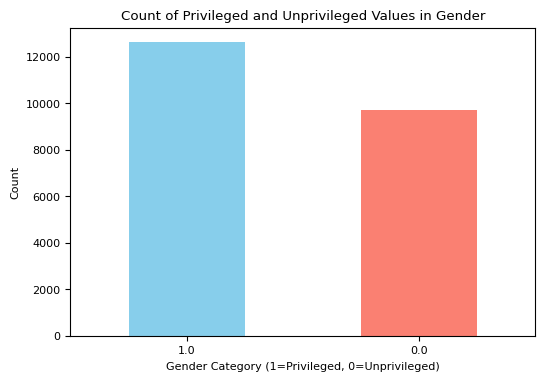

In [64]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [75]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [76]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'y'

In [77]:
df_bank.shape

(20798, 14)

## Display Output

In [65]:
priv_metric_orig_copy = priv_metric_orig

In [66]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 206471.0, 'total_unpriv': 16949.0})

In [67]:
priv_metric_orig

defaultdict(float, {'total_priv': 206471.0, 'total_unpriv': 16949.0})

In [68]:
priv_metric_orig.items()

dict_items([('total_priv', 206471.0), ('total_unpriv', 16949.0)])

In [69]:
priv_metric_orig = priv_metric_orig_copy

In [70]:
orig_metrics.items()

dict_items([('bal_acc', [0.582757750470755, 0.5958752029112696, 0.5816697090296905, 0.5877580968268434, 0.5910598796334279, 0.5887616005129702, 0.5863254057429071, 0.5875541485403427, 0.5864694062819407, 0.5799709394868735, 0.5892721748055172, 0.5839196716505424, 0.5911376272431077, 0.5839549758907552, 0.5791586876570112, 0.5824675729855997, 0.5878829221669977, 0.5824660231120142, 0.5848456135071776, 0.5875654509794732]), ('avg_odds_diff', [-0.5982734672517263, -0.4383311571326717, -0.4084203544748988, -0.5968020580541604, -0.4577174710691193, -0.5142423495503621, -0.5433352599055188, -0.5165418378018298, -0.4200839123442782, -0.52792722051381, -0.45578349264168927, -0.5591547385582392, -0.5786438501117561, -0.6369029870083596, -0.5511241124288089, -0.6058831620592893, -0.4608877212782817, -0.6044843256193013, -0.4956111021320936, -0.4113892905257839]), ('disp_imp', [0.9158585736376663, 0.9067032521367643, 0.9048461985062788, 0.9036701802131752, 0.8707447502559684, 0.9430325875486382, 

In [71]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_race_aif
11171
2)

              total_priv  total_unpriv
num_instance                          
orig            10323.55        847.45
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.300363       0.699637    0.319658      0.680342      0.065315   
transf      0.319629       0.680371    0.319658      0.680342      0.319373   

         unpriv_unfavor  
dataset                  
orig           0.934685  
transf         0.680627  


In [72]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

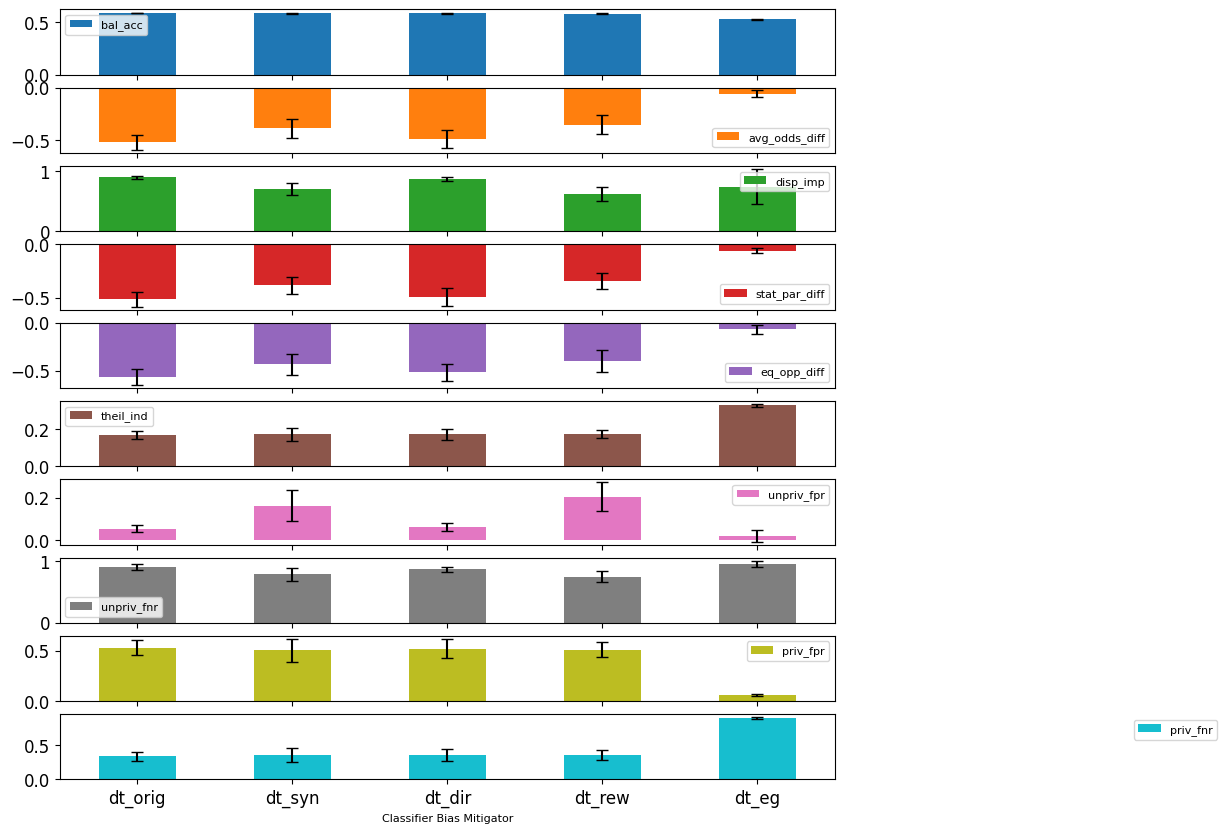

In [73]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [74]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [75]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.518597,0.519305,0.541496,0.527101,0.799938,0.519727,0.538967
syn,0.516570,0.516546,0.535535,0.529604,0.740392,0.516075,0.532996
dir,0.533728,0.541662,0.549046,0.527670,0.806501,0.544310,0.546198
rew,0.517552,0.517822,0.540492,0.525226,0.829838,0.517785,0.535869
eg,0.512465,0.510484,0.522423,0.511084,0.675116,0.510303,0.520486


In [76]:
orig_mia_metrics

defaultdict(list,
            {'entire_dataset_mia_auc': [0.5288299000087674,
              0.5269621447229618,
              0.523760714103324,
              0.5194454593171327,
              0.5217538905635212,
              0.5226839197792736,
              0.5274211673237547,
              0.5205047964864777,
              0.5272408982614413,
              0.5285484339401674,
              0.5216698462033886,
              0.5273207195687717,
              0.5206292363099426,
              0.5272035358635467,
              0.533583923570405,
              0.5295168512668289,
              0.5270621236950437,
              0.5228106834837871,
              0.5246015303269562,
              0.5229603494367044],
             'entire_dataset_mia_privacy_risk': [0.5213051651597888,
              0.5192910213946826,
              0.5188881926416614,
              0.5152179751141348,
              0.5155312863664847,
              0.5179930176349477,
              0.5187091576403187,
    

In [77]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [78]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [79]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.527101,0.799938,0.519727,0.538967
syn,0.529604,0.740392,0.516075,0.532996
dir,0.527670,0.806501,0.544310,0.546198
rew,0.525226,0.829838,0.517785,0.535869
eg,0.511084,0.675116,0.510303,0.520486


<Axes: xlabel='Classifier MIA Attacks'>

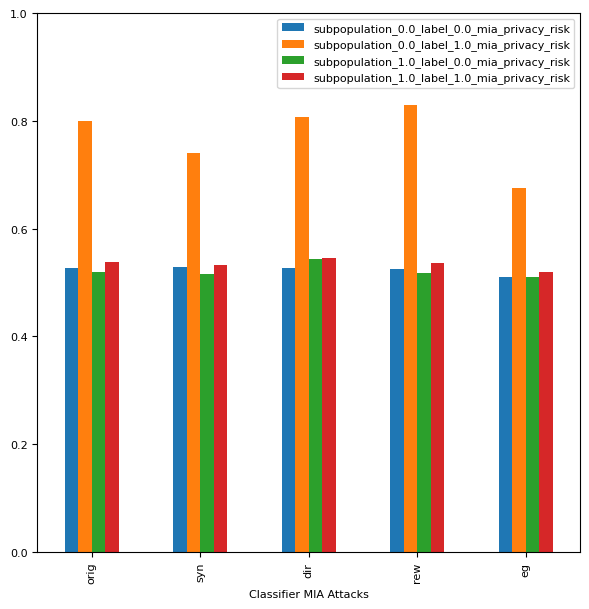

In [80]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [81]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.527101  0.529604  0.52767   0.525226  0.511084
subpopulation_0.0_label_1.0_mia_privacy_risk  0.799938  0.740392  0.806501  0.829838  0.675116
subpopulation_1.0_label_0.0_mia_privacy_risk  0.519727  0.516075  0.54431   0.517785  0.510303
subpopulation_1.0_label_1.0_mia_privacy_risk  0.538967  0.532996  0.546198  0.535869  0.520486


### Visualizing using novel technique

In [95]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


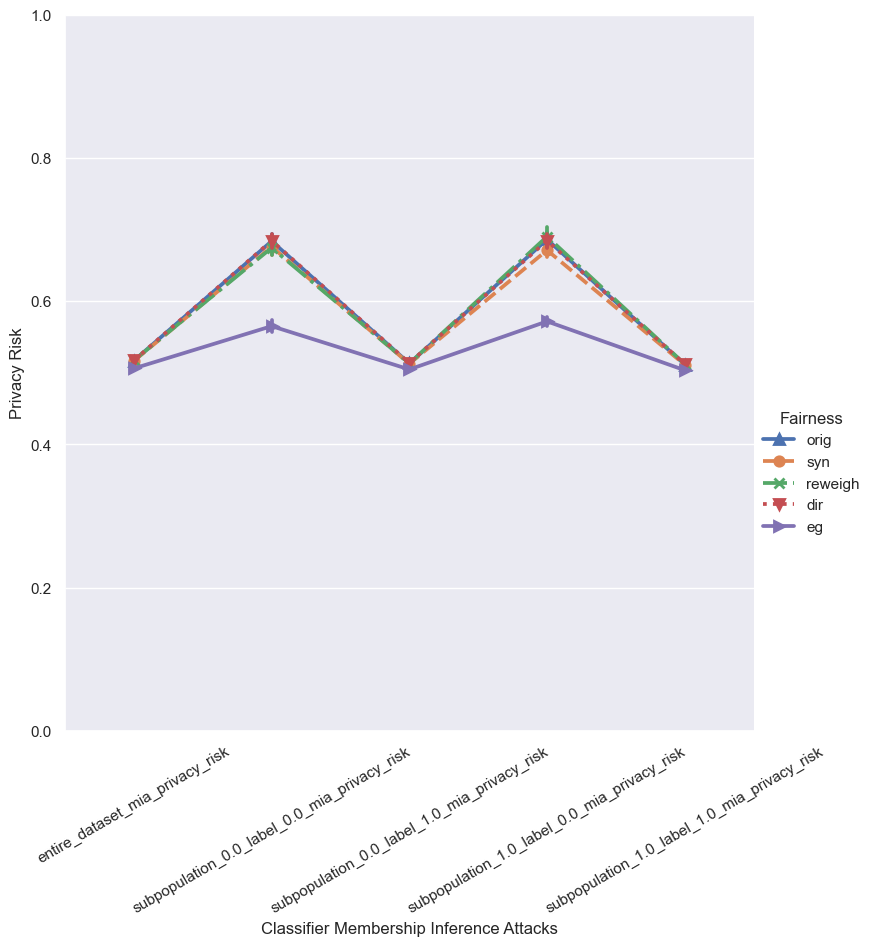

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr